In [2]:
%pylab inline

import torch
import torch.optim as optim
import torch.nn as nn

import numpy as np
from random import randint, seed

# Flag to enable execution on GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Populating the interactive namespace from numpy and matplotlib


In [3]:
n_train_samples = 50000 # number of train samples
n_test_samples = 10000 # number of test samples

groups = np.append(np.zeros(8),np.ones(8)) # 16 groups
print(groups)
np.random.seed(1234)
np.random.shuffle(groups)

# generate samples
seed(1234)
def generate_samples(n_samples):
    x_data = np.zeros((n_samples, 10)) # inputs
    x_int = np.zeros(n_samples) # integers representing the inputs
    y_data = np.zeros((n_samples, 2)) # outputs
    
    for i in range(n_samples):
        random_int = randint(0, 1023)
        x_data[i,:] = [int(b) for b in list("{0:b}".format(random_int).zfill(10))]
        x_int[i] = random_int
        y_data[i,0] = groups[random_int % 16]
        y_data[i,1] = 1 - y_data[i,0]
        
    return x_data, y_data, x_int

x_train, y_train, x_train_int = generate_samples(n_train_samples) # training dataset
x_test, y_test, _ = generate_samples(n_test_samples) # testing dataset

[0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
class MLP(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_classes, neg_slope=0.02):
        super(MLP, self).__init__()

        self.layers = []
        self.num_neurons = [n_inputs] + n_hidden + [n_classes]
        self.models = {}
        for i in range(len(self.num_neurons) - 2):
            self.layers.append(nn.Linear(self.num_neurons[i], self.num_neurons[i+1]))
            # self.layers.append(nn.LeakyReLU(neg_slope))
            self.layers.append(nn.Tanh())
            #self.layers['linear{}'.format(i+1)] = nn.Linear(self.num_neurons[i], self.num_neurons[i+1])
            #self.layers['tanh{}'.format(i+1)] = nn.Tanh()
            self.models['Linear{}'.format(i)] = nn.Sequential(*self.layers)
            

        self.layers.append(nn.Linear(self.num_neurons[i+1], self.num_neurons[i+2]))
        #self.layers['linear{}'.format(i+1)] = nn.Linear(self.num_neurons[i], self.num_neurons[i+1])
        self.models['Output'] = nn.Sequential(*self.layers)
        self.full_model = self.models['Output']
        
        
        
    def forward(self, x, exitLayer=None): 
        if exitLayer is not None:
            out = self.models[exitLayer](x)
        else:
            out = self.full_model(x)
        return out


In [5]:
def get_named_layers(net):
    conv2d_idx = 0
    convT2d_idx = 0
    linear_idx = 0
    batchnorm2d_idx = 0
    named_layers = {}
    for mod in net.modules():
        if isinstance(mod, torch.nn.Conv2d):
            layer_name = 'Conv2d{}_{}-{}'.format(
                conv2d_idx, mod.in_channels, mod.out_channels
            )
            named_layers[layer_name] = mod
            conv2d_idx += 1
        elif isinstance(mod, torch.nn.ConvTranspose2d):
            layer_name = 'ConvT2d{}_{}-{}'.format(
                conv2d_idx, mod.in_channels, mod.out_channels
            )
            named_layers[layer_name] = mod
            convT2d_idx += 1
        elif isinstance(mod, torch.nn.BatchNorm2d):
            layer_name = 'BatchNorm2D{}_{}'.format(
                batchnorm2d_idx, mod.num_features)
            named_layers[layer_name] = mod
            batchnorm2d_idx += 1
        elif isinstance(mod, torch.nn.Linear):
            layer_name = 'Linear{}_{}-{}'.format(
                linear_idx, mod.in_features, mod.out_features
            )
            named_layers[layer_name] = mod
            linear_idx += 1
    return named_layers

def accuracy(predictions, targets):
    accuracy = (predictions.argmax(dim=1) == targets.argmax(dim=1)).type(torch.FloatTensor).mean().item()
    return accuracy

In [6]:
num_epochs = 2000
dnn_hidden_units = [16, 12, 8, 6, 4]
dnn_input_units = x_train.shape[1]
dnn_output_units = y_train.shape[1]
eval_freq = 100

MLP_object = MLP(dnn_input_units, dnn_hidden_units, dnn_output_units).to(device)
get_named_layers(MLP_object)
#MLP_object.parameters()

{'Linear0_10-16': Linear(in_features=10, out_features=16, bias=True),
 'Linear1_16-12': Linear(in_features=16, out_features=12, bias=True),
 'Linear2_12-8': Linear(in_features=12, out_features=8, bias=True),
 'Linear3_8-6': Linear(in_features=8, out_features=6, bias=True),
 'Linear4_6-4': Linear(in_features=6, out_features=4, bias=True),
 'Linear5_4-2': Linear(in_features=4, out_features=2, bias=True)}

In [7]:
def train():

    MLP_object = MLP(dnn_input_units, dnn_hidden_units, dnn_output_units).to(device)
    criterion = nn.CrossEntropyLoss()
    
    optimizer = optim.SGD(MLP_object.parameters(), lr=0.1)#, momentum=0.2)
    
    X_test, Y_test = torch.tensor(x_test, requires_grad=False).to(device), torch.tensor(y_test, requires_grad=False).to(device)
    accuracy_evaluation = {'train': [], 'test': []}
    loss_evaluation = {'train': [], 'test': []}

    start_time = time.time()
    for epoch in range(num_epochs):
        X_train, Y_train = torch.from_numpy(x_train).to(device), torch.from_numpy(y_train).to(device)
        
        optimizer.zero_grad()
        
        out = MLP_object(X_train.float())
        loss = criterion(out, Y_train.argmax(dim=1))
        loss.backward()
        optimizer.step()

        if epoch % eval_freq == 0 or epoch == num_epochs - 1:
            #accuracy_evaluation['train'].append(accuracy(out, y_train))
            #accuracy_evaluation['test'].append(accuracy(MLP_object(X_test), y_test))
            #loss_evaluation['train'].append(loss)
            #loss_evaluation['test'].append(criterion(MLP_object(X_test), Y_test.argmax(dim=1)))
            print('#'*30)
            print('Step - ', epoch)
            print('Train: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(out, Y_train), loss))
            print('Test: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(MLP_object(X_test.float()), Y_test), criterion(MLP_object(X_test.float()), Y_test.argmax(dim=1))))
            print('Time after last eval: ', time.time() - start_time)
            print('#'*30,'\n')
# train()

In [8]:
from collections import Counter

#NumPy implementation for known distribution
def calc_mutual_information(hidden):
    n_neurons = hidden.shape[-1]
  
    # discretization 
    n_bins = 30
    bins = np.linspace(-1, 1, n_bins+1)
    indices = np.digitize(hidden, bins)
    
    # initialize pdfs
    pdf_x = Counter(); pdf_y = Counter(); pdf_t = Counter(); pdf_xt = Counter(); pdf_yt = Counter()

    for i in range(n_train_samples):
        pdf_x[x_train_int[i]] += 1/float(n_train_samples)
        pdf_y[y_train[i,0]] += 1/float(n_train_samples)      
        pdf_xt[(x_train_int[i],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_yt[(y_train[i,0],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_t[tuple(indices[i,:])] += 1/float(n_train_samples)
    
    # calcuate encoder mutual information I(X;T)
    mi_xt = 0
    for i in pdf_xt:
        # P(x,t), P(x) and P(t)
        p_xt = pdf_xt[i]; p_x = pdf_x[i[0]]; p_t = pdf_t[i[1:]]
        # I(X;T)
        mi_xt += p_xt * np.log(p_xt / p_x / p_t)
 
    # calculate decoder mutual information I(T;Y)
    mi_ty = 0
    for i in pdf_yt:
        # P(t,y), P(t) and P(y)
        p_yt = pdf_yt[i]; p_t = pdf_t[i[1:]]; p_y = pdf_y[i[0]]
        # I(T;Y)
        try:
          mi_ty += p_yt * np.log(p_yt / p_t / p_y)
        except ZeroDivisionError:
          mi_ty += p_yt * np.log(p_yt / (p_t + 1e-5) / (p_y + 1e-5))
            
    return mi_xt, mi_ty

# get mutual information for all hidden layers
def get_mutual_information(hidden):
    mi_xt_list = []; mi_ty_list = []
    # for hidden in hiddens:
    if True:
        mi_xt, mi_ty = calc_mutual_information(hidden)
        mi_xt_list.append(mi_xt)
        mi_ty_list.append(mi_ty)
    return mi_xt_list, mi_ty_list




# Neural approximation of MI starts here
# Auxiliary network for mutual information estimation
class MIEstimator(nn.Module):
    def __init__(self, size1, size2):
        super(MIEstimator, self).__init__()
        
        # Vanilla MLP
        self.net = nn.Sequential(
            nn.Linear(size1 + size2, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1),
        )
    
    # Gradient for JSD mutual information estimation and EB-based estimation
    def forward(self, x1, x2):
        # breakpoint()
        pos = self.net(torch.cat([x1, x2], 1)) #Positive Samples 
        neg = self.net(torch.cat([torch.roll(x1, 1, 0), x2], 1)) #Predictions for shuffled (negative) samples from p(z1)p(z2)
        #breakpoint()
        return -softplus(-pos).mean() - softplus(neg).mean(), pos.mean() - neg.exp().mean() + 1

We are now able to estimate the mutual information while training the network. We'll save the mutual information for later use.

In [9]:
class Scheduler:
    def __call__(self, **kwargs):
        raise NotImplemented()

class LinearScheduler(Scheduler):
    def __init__(self, start_value, end_value, n_iterations, start_iteration=0):
        self.start_value = start_value
        self.end_value = end_value
        self.n_iterations = n_iterations
        self.start_iteration = start_iteration
        self.m = (end_value - start_value) / n_iterations

    def __call__(self, iteration):
        if iteration > self.start_iteration + self.n_iterations:
            return self.end_value
        elif iteration <= self.start_iteration:
            return self.start_value
        else:
            return (iteration - self.start_iteration) * self.m + self.start_value

class ExponentialScheduler(LinearScheduler):
    def __init__(self, start_value, end_value, n_iterations, start_iteration=0, base=10):
        self.base = base

        super(ExponentialScheduler, self).__init__(start_value=math.log(start_value, base),
                                                   end_value=math.log(end_value, base),
                                                   n_iterations=n_iterations,
                                                   start_iteration=start_iteration)

    def __call__(self, iteration):
        linear_value = super(ExponentialScheduler, self).__call__(iteration)
        return self.base ** linear_value

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.autograd import Variable

import time
from numbers import Number

class VariationalMI(nn.Module):

    def __init__(self, K=6):
        super(VariationalMI, self).__init__()
        self.K = K

        self.encode = nn.Sequential(
            nn.Linear(10, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 2*self.K))

        self.decode = nn.Sequential(
                nn.Linear(self.K, 2))

    def forward(self, x, num_sample=1):
        if x.dim() > 2 : x = x.view(x.size(0),-1)

        statistics = self.encode(x)
        mu = statistics[:,:self.K]
        std = F.softplus(statistics[:,self.K:]-5,beta=1)

        encoding = self.reparametrize_n(mu,std,num_sample)
        logit = self.decode(encoding)

        if num_sample == 1 : pass
        elif num_sample > 1 : logit = F.softmax(logit, dim=2).mean(0)

        return (mu, std), logit

    def reparametrize_n(self, mu, std, n=1):
        # reference :
        # http://pytorch.org/docs/0.3.1/_modules/torch/distributions.html#Distribution.sample_n
        def expand(v):
            if isinstance(v, Number):
                return torch.Tensor([v]).expand(n, 1)
            else:
                return v.expand(n, *v.size())

        if n != 1 :
            mu = expand(mu)
            std = expand(std)

        eps = Variable(std.data.new(std.size()).normal_().to(device))

        return mu + eps * std

    def weight_init(self):
        for m in self._modules:
            xavier_init(self._modules[m])


def xavier_init(ms):
    for m in ms :
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform(m.weight,gain=nn.init.calculate_gain('relu'))
            m.bias.data.zero_()

In [19]:
from torch.optim import Adam
from torch.nn.functional import softplus
from collections import OrderedDict
# from data_utils import ExponentialScheduler



num_epochs = 100
# dnn_hidden_units = [10, 64, 32, 16, 8, 4]
dnn_hidden_units = [10, 8, 6, 4]
x_dim = dnn_input_units = x_train.shape[1]
y_dim = dnn_output_units = y_train.shape[1]
z_dim = dnn_hidden_units[-1]
eval_freq = 10


# Defining the schedule for the update of the hyper-parameter over time
beta_scheduler = ExponentialScheduler(start_value=1e-3, end_value=1, n_iterations=num_epochs, start_iteration=10)

def get_hidden_layers(net, names, input_tensor):
    # with torch.no_grad():
    if True:
        #hidden_layers_output = {}
        hidden_layers_output = []
        for name in names:
#             hidden_layers_output[name] = net(input_tensor.float(), exitLayer=name).data.numpy()
            hidden_layers_output.append(net(input_tensor.float(), exitLayer=name).to(device))#.data.numpy())
    return hidden_layers_output

# train the neural network and obtain mutual information
def train_with_mi(X_train, Y_train, X_test, Y_test, load=False):
    t_names = ['Linear0', 'Linear1', 'Linear2', 'Linear3']
    mi_xt_all = []; mi_ty_all = []; epochs = []
    mi_xz = []; mi_zy = []
    
    # MLP_object = MLP(dnn_input_units, dnn_hidden_units, dnn_output_units).to(device)
    # mi_estimator_X = MIEstimator(x_dim, z_dim).to(device)
    # mi_estimator_Y = MIEstimator(z_dim, y_dim).to(device)
    # print(get_named_layers(MLP_object))
    



    # criterion = nn.CrossEntropyLoss()
    
    #optimizer = optim.SGD(MLP_object.parameters(), lr=0.1)#, momentum=0.2)

#     optimizer_D = Adam([
#     {'params': MLP_object.parameters(), 'lr':1e-2},
# #     {'params': encoder_v_2.parameters(), 'lr':1e-4}, # There is only one encoder in this example
#     ])
#     optimizer_G = Adam([
#     {'params': mi_estimator_X.parameters(), 'lr':1e-4},
#     #{'params': mi_estimator_Y.parameters(), 'lr':1e-4},
# ])
    
    
    VaMI = VariationalMI(z_dim).to(device)
    if load == True:
      print('Downloading pre-trained model')
      VaMI.load_state_dict(torch.load('vib_mi.pt'))
    else:
      print('Initializing very new MI estimator')
      VaMI.weight_init()

    optimizer = optim.Adam(VaMI.parameters(),lr=1e-2,betas=(0.5,0.999))
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.97)
    
    accuracy_evaluation = {'train': [], 'test': []}
    loss_evaluation = {'train': [], 'test': []}
    start_time = time.time()
    for epoch in range(num_epochs):
        beta = beta_scheduler(epoch)
        '''

        encoding = get_hidden_layers(MLP_object, t_names, X_train)
        print(len(encoding))
        
        optimizer_D.zero_grad()
        out =  MLP_object(X_train.float())
        # mi_gradient_X, mi_estimation_X = mi_estimator_X(X_train, encoding[-1])
        # mi_gradient_X = mi_gradient_X.mean()
        # mi_estimation_X = mi_estimation_X.mean()

        loss = criterion(out, Y_train.argmax(dim=1))# - beta * mi_gradient_X
        loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        mi_gradient_X, mi_estimation_X = mi_estimator_X(X_train, encoding[-1])
        mi_gradient_X = mi_gradient_X.mean()
        mi_estimation_X = mi_estimation_X.mean()

        mi_gradient_Y, mi_estimation_Y = mi_estimator_Y(encoding[-1], Y_train.float())
        mi_gradient_Y = mi_gradient_Y.mean()
        mi_estimation_Y = mi_estimation_Y.mean()
                
        loss_mi = beta * mi_gradient_X - (1- beta) * mi_gradient_Y
        loss_mi.backward()
        optimizer_G.step()
        '''


        (mu, std), logit = VaMI(X_train)
        
        class_loss = F.cross_entropy(logit, Y_train.argmax(dim=1)).div(math.log(2))
        info_loss = -0.5 * (1 + 2 * std.log() - mu.pow(2) - std.pow(2)).sum(1).mean().div(math.log(2))
        total_loss = class_loss + beta * info_loss

        izy_bound = math.log(10,2) - class_loss
        izx_bound = info_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        # self.toynet_ema.update(self.toynet.state_dict())

        prediction = F.softmax(logit,dim=1).max(1)[1]
        accuracy = torch.eq(prediction,Y_train.argmax(1)).float().mean()

        z_samples = torch.randn(z_dim).to(device) * std + mu
        torch.save(VaMI.state_dict(), 'vib_mi.pt')
            
        eval_freq = 1
        if epoch % eval_freq == 0 or epoch == num_epochs - 1:
            mi_xt, mi_ty = get_mutual_information(z_samples.cpu().data.numpy())
            mi_xt_all.append(mi_xt)
            mi_ty_all.append(mi_ty)
            mi_xz.append(izx_bound.item())
            mi_zy.append(izy_bound.item())
            
            epochs.append(epoch)
            accuracy_evaluation['train'].append(accuracy)
            #accuracy_evaluation['test'].append(accuracy(MLP_object(X_test), y_test))
            #loss_evaluation['train'].append(loss)
            #loss_evaluation['test'].append(criterion(MLP_object(X_test), Y_test.argmax(dim=1)))
            print('#'*30)
            print('Step - ', epoch)
            print('Beta - ', beta)
            print('Train: Accuracy - %0.3f, Loss - %0.3f' % (accuracy, total_loss))#(accuracy(out, Y_train), loss))
            # print('Test: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(MLP_object(X_test), Y_test), criterion(MLP_object(X_test), Y_test.argmax(dim=1))))
            print('I(X, T) - ', mi_xt)
            print('I(T, Y) - ', mi_ty)
            # print('I_est(X, T)', mi_estimation_X)
            # print('Grad I_est(X, T)', mi_gradient_X)
            # print('I_est(T, Y)', mi_estimation_Y)
            # print('Grad I_est(T, Y)', mi_gradient_Y)
            print('I_est(X, T)', izx_bound.item())
            print('I_est(T, Y)', izy_bound.item())
            print('Time running: ', time.time() - start_time)
            print('#'*30,'\n')
    
    return np.array(mi_xt_all), np.array(mi_ty_all), np.array(epochs), mi_xz, mi_zy, accuracy_evaluation['train']


def numpy(x):
  if type(x) == type(np.array([])):
    return True
  else:
    return False

if numpy(x_train):
    x_train = torch.FloatTensor(x_train).to(device)
if numpy(y_train):
    y_train = torch.FloatTensor(y_train).to(device)
if numpy(x_test):
    x_test = torch.from_numpy(x_test).to(device)
if numpy(y_test):
    y_test = torch.from_numpy(y_test).to(device)
mi_xt_all, mi_ty_all, epochs, mi_xz, mi_zy, accuracy_val = train_with_mi(x_train.float(), y_train.float(), x_test.float(), y_test.float())

Initializing very new MI estimator


/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


##############################
Step -  0
Beta -  0.001000000000000001
Train: Accuracy - 0.468, Loss - 1.092
I(X, T) -  [6.472722217864495]
I(T, Y) -  [7.158611099720596]
I_est(X, T) 26.717615127563477
I_est(T, Y) 2.256580352783203
Time running:  6.588933944702148
############################## 

##############################
Step -  1
Beta -  0.001000000000000001
Train: Accuracy - 0.504, Loss - 22.272
I(X, T) -  [0.007491010902524771]
I(T, Y) -  [0.7006182443301129]
I_est(X, T) 191.12730407714844
I_est(T, Y) -18.759342193603516
Time running:  12.252548933029175
############################## 

##############################
Step -  2
Beta -  0.001000000000000001
Train: Accuracy - 0.503, Loss - 2.336
I(X, T) -  [4.746489299764621]
I(T, Y) -  [5.4353650271358225]
I_est(X, T) 22.599742889404297
I_est(T, Y) 1.0082604885101318
Time running:  17.369511127471924
############################## 

##############################
Step -  3
Beta -  0.001000000000000001
Train: Accuracy - 0.612, Los

KeyboardInterrupt: 

In [178]:
accuracy_val

[tensor(0.5359, device='cuda:0')]

## Visualization

Below is a movie showing the evolution of the hidden layers with the training epochs in the information plane. We can clearly see two distinct optimization phases in the information plane, as discussed in the paper. During the first *empirical error minimization* (ERM) phase (until around epoch 1500), the information on the outputs $I_Y$ increases quickly, and then during the second *representation compression* phase (from around epoch 1500 onwards), the information on the inputs $I_X$ decreases. The evolution is not as smooth as shown in the paper, because it is the result of only one network, instead of average of multiple networks. 

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [0]:
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((3,7))
ax.set_ylim((0.1,0.7))
ax.set_xlabel('I(X;T)')
ax.set_ylabel('I(T;Y)')
title = ax.set_title('')
plt.close(fig)

In [166]:
mi_xt_all[0:2, 0]

array([6.36888365, 0.90910914])

In [170]:
cmap = plt.cm.get_cmap('cool')

def animate(i):
    title.set_text('Epoch %s' % str(epochs[i]).zfill(4))
    # print(mi_xt_all[i], mi_ty_all[i])
    ax.plot(mi_xt_all[i], mi_ty_all[i], 'k-',alpha=0.2)
    if i > 0:
        for j in range(1):
            ax.plot(mi_xt_all[(i-1):(i+1),j],mi_ty_all[(i-1):(i+1),j])#,'.-',c=cmap(j*.2),ms=10)
        print(mi_xt_all[i], mi_ty_all[i])
        #ax.plot(mi_xt_all[(i-1):(i+1)],mi_ty_all[(i-1):(i+1), 0],'.-',c=cmap(i*.2),ms=10)
    return

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=None,
                               frames=len(epochs),
                               interval=100)
HTML(anim.to_html5_video())

[0.90910914] [1.60164888]
[1.66350867] [2.35586873]
[5.18819977] [5.8782673]
[5.31825192] [6.00836837]
[5.10445855] [5.79483448]
[5.22813027] [5.91804841]
[5.64109224] [6.33025303]
[5.89607748] [6.58432307]
[5.93557553] [6.6235627]


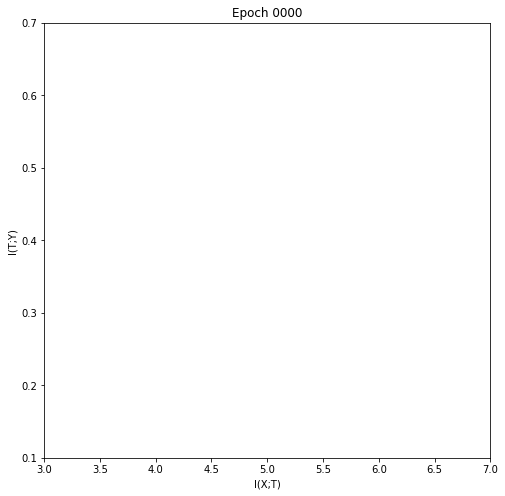

In [169]:
ax.set_title('Epoch 0000 - 2999')
fig # show full evolution process

In [0]:
class Predictor(nn.Module):
    def __init__(self, n_inputs, n_hidden, n_classes):
        super(Predictor, self).__init__()

        self.layers = []
        self.num_neurons = [n_inputs] + n_hidden + [n_classes]
        self.models = {}
        
        if n_hidden == []:
            self.layers.append(nn.Linear(self.num_neurons[0], self.num_neurons[1]))
        else:
            for i in range(len(self.num_neurons) - 2):
                self.layers.append(nn.Linear(self.num_neurons[i], self.num_neurons[i+1]))
                # self.layers.append(nn.LeakyReLU(neg_slope))
                self.layers.append(nn.Tanh())
                #self.layers['linear{}'.format(i+1)] = nn.Linear(self.num_neurons[i], self.num_neurons[i+1])
                #self.layers['tanh{}'.format(i+1)] = nn.Tanh()
                self.models['Linear{}'.format(i)] = nn.Sequential(*self.layers)


            self.layers.append(nn.Linear(self.num_neurons[i+1], self.num_neurons[i+2]))
        self.models['Output'] = nn.Sequential(*self.layers)
        self.full_model = self.models['Output']
        
        
        
    def forward(self, x, exitLayer=None): 
        if exitLayer is not None:
            out = self.models[exitLayer](x)
        else:
            out = self.full_model(x)
        return out


    
def train_given_z(n_train_samples, exit_layer, num_epochs=2000, dnn_hidden_units=[]):
    
    x_train, y_train, x_train_int = generate_samples(n_train_samples) # training dataset
    x_test, y_test, _ = generate_samples(n_test_samples) # testing dataset
    X_test, Y_test = torch.tensor(x_test, requires_grad=False).to(device), torch.tensor(y_test, requires_grad=False).to(device)

    z_test = torch.tensor(MLP_object(X_test.float(), exitLayer=exit_layer), requires_grad=False).to(device)
    predictor = Predictor(z_test.size(1), dnn_hidden_units, Y_test.size(1)).to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(predictor.parameters(), lr=0.1)#, momentum=0.2)

    accuracy_evaluation = {'train': [], 'test': []}
    loss_evaluation = {'train': [], 'test': []}

    start_time = time.time()
    for epoch in range(num_epochs):
        X_train, Y_train = torch.from_numpy(x_train).to(device), torch.from_numpy(y_train).to(device)
        z_train = MLP_object(X_train.float(), exitLayer=exit_layer)
        optimizer.zero_grad()
        out =  predictor(z_train.float())
        loss = criterion(out, Y_train.argmax(dim=1))
        loss.backward()
        optimizer.step()
        if epoch % eval_freq == 0 or epoch == num_epochs - 1:
            accuracy_evaluation['train'].append(accuracy(out, Y_train))
            accuracy_evaluation['test'].append(accuracy(predictor(MLP_object(X_test.float(), exitLayer=exit_layer)), Y_test))
            #loss_evaluation['train'].append(loss)
            #loss_evaluation['test'].append(criterion(MLP_object(X_test), Y_test.argmax(dim=1)))
            print('#'*30)
            print('Step - ', epoch)
            print('Train: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(out, Y_train), loss))
            print('Test: Accuracy - %0.3f, Loss - %0.3f' % (accuracy(predictor(z_test.float()), Y_test), criterion(predictor(z_test.float()), Y_test.argmax(dim=1))))
            print('Time after last eval: ', time.time() - start_time)
            print('#'*30,'\n')
    return np.max(accuracy_evaluation['test'])#np.mean(accuracy_evaluation['test'][-5:])

data_step = 5000
acc = {}
num_labels_range = np.arange(10000, n_train_samples+data_step, data_step)
for layer in ['Linear1', 'Linear2']:
    acc[layer] = []
    for num_labels in num_labels_range:
        print('Running for %s %s' % (layer, num_labels))
        acc[layer].append(train_given_z(num_labels, layer, num_epochs=500))

Running for Linear1 10000
##############################
Step -  0
Train: Accuracy - 0.498, Loss - 0.740
Test: Accuracy - 0.498, Loss - 0.733
Time after last eval:  0.007537364959716797
############################## 



/Users/ntokoven/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


##############################
Step -  100
Train: Accuracy - 0.573, Loss - 0.685
Test: Accuracy - 0.586, Loss - 0.685
Time after last eval:  0.3782060146331787
############################## 

##############################
Step -  200
Train: Accuracy - 0.576, Loss - 0.683
Test: Accuracy - 0.587, Loss - 0.682
Time after last eval:  0.6896970272064209
############################## 

##############################
Step -  300
Train: Accuracy - 0.580, Loss - 0.680
Test: Accuracy - 0.589, Loss - 0.679
Time after last eval:  1.0402953624725342
############################## 

##############################
Step -  400
Train: Accuracy - 0.584, Loss - 0.678
Test: Accuracy - 0.590, Loss - 0.677
Time after last eval:  1.3735401630401611
############################## 

##############################
Step -  499
Train: Accuracy - 0.579, Loss - 0.677
Test: Accuracy - 0.587, Loss - 0.675
Time after last eval:  1.7910621166229248
############################## 

Running for Linear1 15000
#########

##############################
Step -  100
Train: Accuracy - 0.550, Loss - 0.691
Test: Accuracy - 0.549, Loss - 0.691
Time after last eval:  1.5768342018127441
############################## 

##############################
Step -  200
Train: Accuracy - 0.573, Loss - 0.686
Test: Accuracy - 0.578, Loss - 0.686
Time after last eval:  3.356574296951294
############################## 

##############################
Step -  300
Train: Accuracy - 0.574, Loss - 0.683
Test: Accuracy - 0.580, Loss - 0.683
Time after last eval:  4.754821300506592
############################## 

##############################
Step -  400
Train: Accuracy - 0.588, Loss - 0.680
Test: Accuracy - 0.590, Loss - 0.680
Time after last eval:  6.143790245056152
############################## 

##############################
Step -  499
Train: Accuracy - 0.593, Loss - 0.678
Test: Accuracy - 0.594, Loss - 0.678
Time after last eval:  7.420387268066406
############################## 

Running for Linear1 50000
#############

##############################
Step -  100
Train: Accuracy - 0.563, Loss - 0.687
Test: Accuracy - 0.563, Loss - 0.687
Time after last eval:  1.366257905960083
############################## 

##############################
Step -  200
Train: Accuracy - 0.567, Loss - 0.685
Test: Accuracy - 0.566, Loss - 0.685
Time after last eval:  2.8408658504486084
############################## 

##############################
Step -  300
Train: Accuracy - 0.569, Loss - 0.684
Test: Accuracy - 0.568, Loss - 0.684
Time after last eval:  4.306330919265747
############################## 

##############################
Step -  400
Train: Accuracy - 0.572, Loss - 0.683
Test: Accuracy - 0.572, Loss - 0.683
Time after last eval:  5.496225833892822
############################## 

##############################
Step -  499
Train: Accuracy - 0.573, Loss - 0.682
Test: Accuracy - 0.573, Loss - 0.682
Time after last eval:  6.53233003616333
############################## 

Running for Linear2 40000
##############

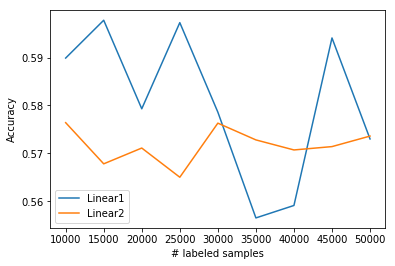

In [0]:
plt.plot(num_labels_range, acc['Linear1'], label='Linear1')
plt.plot(num_labels_range, acc['Linear2'], label='Linear2')
plt.xlabel('# labeled samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

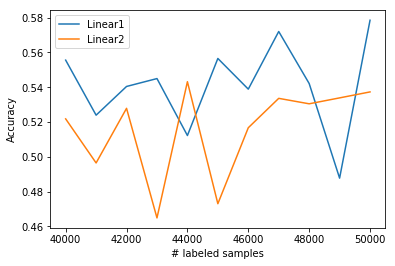

In [0]:
plt.plot(num_labels_range, acc['Linear1'], label='Linear1')
plt.plot(num_labels_range, acc['Linear2'], label='Linear2')
plt.xlabel('# labeled samples')
plt.ylabel('Accuracy')
plt.legend()
plt.show()